# Housing Insecurity Project, [DataKind Data Dive](https://datadive.datakind.org/) 

Written by Laura Prichard, 2 October 2021

**Objectives**

- Using data on housing loss to find factors that can reduce housing insecurity. 
- Predict a fair market rent price for social housing based on local housing market information from census data.
- Model can be used to easily identify overpriced social housing so it can be adjusted accordingly to help reduce housing loss.

**Data**

- From the [DataKind Data Dive](https://datadive.datakind.org/) (18 September 2021), Housing Insecurity Project, in partnership with [New America](https://www.newamerica.org/)’s [Future of Land and Housing](https://www.newamerica.org/future-land-housing/) program.
- The data used for analysis include National Housing Preservation Database (NHPD) and American Community Survey (ACS) housing loss data from Florida’s Hillsborough, Miami-Dade, and Orange counties.
- [**Housing Insecurity Project**](https://docs.google.com/document/d/1ovSvMK39wO6NXqCrH0chQL7aRHR6Lr0vQIzXhmUEBFk/edit) | [Project GitHub](https://github.com/datakind/sep21-housing-insecurity) | [Tasks](https://docs.google.com/spreadsheets/d/1H4KZ31jKkhyBYXAlYm_Bw-RjTNkVoeskye0GwtbPuvM/edit?pli=1#gid=0) | [Data Folder](https://drive.google.com/drive/folders/19B0xzeRyozYJDxwXKlGIPFe3Qnc3nfux)
- Previously performed (see HousingInsecurity_DataKind_EDA.ipynb):
    - Exploratory Data Analysis on the National Housing Preservation Database (NHPD) 
    - Some data cleaning to homogenize column formats and variables, already complete. 
    - Code from others to combine data from different sources.

**Skills**
- Data Cleaning
- Exploratory Data Analysis
- Feature Engineering
- Testing of Feature Importance
- Predictive Modeling
- Hyperparameter Tuning (with `GridSearchCV`)
- Training & Testing Models
    - Linear Regression
    - Linear Regression with Polynomial Features
    - Ridge Regression
- Cross Validation

**Overview**

This investigation aimed to predict fair market rent for social housing based on local housing market metrics. The primary objective of the project was to test and generate a model of prediction that could be used to identify areas where the fair market rent is priced too high, which may contribute to housing loss.

Starting from a combination of large data sets, the NHPD (252 columns, 82287 rows) and ACS (73 columns, 1047 rows), the data were combined, aggregated by census tract data and cleaned ready for analysis. 

Using data exploration, the most useful and important features were selected (`median-monthly-housing-cost`, `median-property-value`, `median-gross-rent`) for predicting the target variable (`FairMarketRent_2BR`). The data were transformed for testing the models, a boxcox transformation was used for the target variable and the predictive data were scaled using the `StandardScalar` tool. 

Three models were trained and tested:
- MODEL 1: Regular Linear Regression
- MODEL 2: Linear Regression with Polynomial Features (degree=2)
- MODEL 3: Ridge Regression
The models were cross-validated using an R^2 score. Model 2 returned the smallest R^2 score and was deemed the best fitting model and easy to interpret and apply to the data for other users.

Many features in the database have no correlation to the fair market rent predictions listed (e.g., number of units). Work was done to identify the best features for prediction and each of the three used show a significant correlation with the target variable. These features may have common prediction origins and therefore be too closely correlated. However, given their independent sources, they were deemed okay for this analysis.

**Conclusions**

Based on cross validation with the R^2 score, the best fitting model is **MODEL 2: Linear Regression with Polynomial Features (degree=2)**. This model is relatively simple, and is easy to interpret. This is the ideal model to therefore be used for predicting where fair market rents are being overestimated based on other local housing market metrics due to its straight forward application.

**Next Steps**

- More investigation into important features.
- Incorporating more values from the large amount of housing data may help improve the model. 
- This analysis is based on only three counties worth of data in Florida. Expanding this analysis to more counties would be interesting to see how the relation between these predictive metrics and the target variables varies by area across the US.

In [1]:
import os
import copy
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats.mstats import normaltest

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# pd.options.display.max_rows = 100

# 1. Load, clean, combine, group data

In [2]:
# Set data directory
data_root = "/Users/lprichard/Dropbox/Data_Science/DataKind_18Sep21/"
os.chdir(data_root)

# Load in data
df = pd.read_excel('./data/National_Housing_Preservation_Database/Active_and_Inconclusive_Properties.xlsx')
display(df.head())
display(df.info())

,NHPDPropertyID,PropertyName,PropertyAddress,City,State,Zip,CBSACode,CBSAType,County,CountyCode,...,NumberActiveMR,NumberInconclusiveMR,NumberInactiveMR,Mr_1_Status,Mr_1_ProgramName,Mr_1_AssistedUnits,Mr_2_Status,Mr_2_ProgramName,Mr_2_AssistedUnits,OldNHPDPropertyID
0,1000000,IVY ESTATES,6729 Zeigler Blvd,Mobile,AL,36608-4253,33660.0,Metropolitan Statistical Area,Mobile,1097.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000001,RENDU TERRACE WEST,7400 Old Shell Rd,Mobile,AL,36608-4549,33660.0,Metropolitan Statistical Area,Mobile,1097.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000002,TWB RESIDENTIAL OPPORTUNITIES II,93 Canal Rd,Port Jefferson Station,NY,11776-3024,35620.0,Metropolitan,Suffolk,36103.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000003,THE DAISY HOUSE,615 Clarissa St,Rochester,NY,14608-2485,40380.0,Metropolitan,Monroe,36055.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000004,MAIN AVENUE APARTMENTS,105 E Walnut St,Sylacauga,AL,35150-3012,45180.0,Micropolitan Statistical Area,Talladega,1121.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82287 entries, 0 to 82286
Columns: 252 entries, NHPDPropertyID to OldNHPDPropertyID
dtypes: datetime64[ns](42), float64(73), int64(41), object(96)
memory usage: 158.2+ MB


None

In [3]:
df.columns.to_list()

['NHPDPropertyID',
 'PropertyName',
 'PropertyAddress',
 'City',
 'State',
 'Zip',
 'CBSACode',
 'CBSAType',
 'County',
 'CountyCode',
 'CensusTract',
 'CongressionalDistrict',
 'Latitude',
 'Longitude',
 'PropertyStatus',
 'ActiveSubsidies',
 'TotalInconclusiveSubsidies',
 'TotalInactiveSubsidies',
 'TotalUnits',
 'EarliestStartDate',
 'EarliestEndDate',
 'LatestEndDate',
 'Owner',
 'OwnerType',
 'ManagerName',
 'ManagerType',
 'HUDPropertyID',
 'ReacScore1',
 'ReacScore1Date',
 'ReacScore2',
 'ReacScore2Date',
 'ReacScore3',
 'ReacScore3Date',
 'StudioOneBedroomUnits',
 'TwoBedroomUnits',
 'ThreePlusBedroomUnits',
 'PercentofELIHouseholds',
 'TargetTenantType',
 'FairMarketRent_2BR',
 'EarliestConstructionDate',
 'LatestConstructionDate',
 'OccupancyRate',
 'AverageMonthsOfTenancy',
 'NumberActiveSection8',
 'NumberInconclusiveSection8',
 'NumberInactiveSection8',
 'S8_1_ID',
 'S8_1_Status',
 'S8_1_ProgramName',
 'S8_1_RenewalStatus',
 'S8_1_StartDate',
 'S8_1_EndDate',
 'S8_1_Assist

In [4]:
# Homogenizing column formats
data_in = copy.deepcopy(df)
data_in['PropertyName'] = data_in['PropertyName'].str.upper()
data_in['PropertyAddress'] = data_in['PropertyAddress'].str.title()
data_in['City'] = data_in['City'].str.title()
data_in['County'] = data_in['County'].str.title()
data_in['Owner'] = data_in['Owner'].str.upper()
data_in['ManagerName'] = data_in['ManagerName'].str.upper()

# Replace state name for Guam
data_in['State'].loc[data_in['State']=='WP'] = 'GU'

# Target Tenant Type cleaning
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("Eldery or Disabled", "Elderly or Disabled")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("Mixed;Link", "Mixed")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("Indv. families - not eld/ handicap", "Family")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("Senior", "Elderly")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("Family & Elderly", "Mixed")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("Homeless Veterans", "Veterans")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("Mixed Income", "Mixed")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("OTHER", "Mixed")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.replace("Affordable", "Low Income")
data_in['TargetTenantType'] = data_in['TargetTenantType'].str.title()

/Users/lprichard/miniconda3/envs/a37_ml/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/lprichard/miniconda3/envs/a37_ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


In [5]:
# Code from Merrick Usta
# import gdown
# #Read housing loss data
# #Hillsborough
# url = 'https://drive.google.com/uc?id=1abt4fLPO__KxBLz9SXue5VKeZN3cUcCF&export=download'
# output = './data/hills_loss.csv'
# gdown.download(url, output, quiet=False)
# #Miami-Dade
# url = 'https://drive.google.com/uc?id=1gLojTGS6HQ1s60gmIxFCq2xObB1634BU&export=download'
# output = './data/miami_loss.csv'
# gdown.download(url, output, quiet=False)
# #Orange
# url = 'https://drive.google.com/uc?id=15ee2QrH8a_yuIfptGwAsVF-tWGTEYXCy&export=download'
# output = './data/orange_loss.csv'
# gdown.download(url, output, quiet=False)
housing_loss=pd.concat([pd.read_csv('./data/hills_loss.csv'),
                       pd.read_csv('./data/miami_loss.csv'),
                       pd.read_csv('./data/orange_loss.csv')])

#Get census tracts, compare with those in NHPD data
housing_loss.rename(columns={'census_tract_GEOID':'CensusTract'},inplace=True)

# LP added
nhpd_data = copy.deepcopy(data_in)
nhpd_data = nhpd_data.merge(housing_loss,how="inner",on=['CensusTract'])

In [6]:
housing_loss.shape

(1047, 73)

In [7]:
# Get data info
display(nhpd_data.head())
display(nhpd_data.info())
nhpd_data.columns.to_list()

,NHPDPropertyID,PropertyName,PropertyAddress,City,State,Zip,CBSACode,CBSAType,County,CountyCode,...,lien-foreclosure-rate-2019,avg-eviction-rate,ratio-to-mean-foreclosure-rate,ratio-to-mean-eviction-rate,avg-housing-loss-rate,evictions-pct-total-housing-loss,housing-loss-index,county_GEOID,county,state
0,1000163,BUENA VISTA APARTMENTS,521 Sw 6Th St,Miami,FL,33130-2773,33100.0,Metropolitan Statistical Area,Miami-Dade,12086.0,...,0.0,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893,12086,Miami-Dade County,Florida
1,1000165,VILLA BEATRIZ,776 Nw 2Nd St,Miami,FL,33128-1454,33100.0,Metropolitan Statistical Area,Miami-Dade,12086.0,...,0.0,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893,12086,Miami-Dade County,Florida
2,1000613,JOE MORETTI II,535 Sw 6Th St,Miami,FL,33130-2745,33100.0,Metropolitan Statistical Area,Miami-Dade,12086.0,...,0.0,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893,12086,Miami-Dade County,Florida
3,1014273,HUNTER RIVER WALK APARTMENTS,524 Nw 1St St,Miami,FL,33128-1572,33100.0,Metropolitan Statistical Area,Miami-Dade,12086.0,...,0.0,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893,12086,Miami-Dade County,Florida
4,1018226,VILLA SARA,435 Sw 6Th St,Miami,FL,33130-2875,33100.0,Metropolitan Statistical Area,Miami-Dade,12086.0,...,0.0,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893,12086,Miami-Dade County,Florida


<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 0 to 909
Columns: 324 entries, NHPDPropertyID to state
dtypes: datetime64[ns](42), float64(113), int64(71), object(98)
memory usage: 2.3+ MB


None

['NHPDPropertyID',
 'PropertyName',
 'PropertyAddress',
 'City',
 'State',
 'Zip',
 'CBSACode',
 'CBSAType',
 'County',
 'CountyCode',
 'CensusTract',
 'CongressionalDistrict',
 'Latitude',
 'Longitude',
 'PropertyStatus',
 'ActiveSubsidies',
 'TotalInconclusiveSubsidies',
 'TotalInactiveSubsidies',
 'TotalUnits',
 'EarliestStartDate',
 'EarliestEndDate',
 'LatestEndDate',
 'Owner',
 'OwnerType',
 'ManagerName',
 'ManagerType',
 'HUDPropertyID',
 'ReacScore1',
 'ReacScore1Date',
 'ReacScore2',
 'ReacScore2Date',
 'ReacScore3',
 'ReacScore3Date',
 'StudioOneBedroomUnits',
 'TwoBedroomUnits',
 'ThreePlusBedroomUnits',
 'PercentofELIHouseholds',
 'TargetTenantType',
 'FairMarketRent_2BR',
 'EarliestConstructionDate',
 'LatestConstructionDate',
 'OccupancyRate',
 'AverageMonthsOfTenancy',
 'NumberActiveSection8',
 'NumberInconclusiveSection8',
 'NumberInactiveSection8',
 'S8_1_ID',
 'S8_1_Status',
 'S8_1_ProgramName',
 'S8_1_RenewalStatus',
 'S8_1_StartDate',
 'S8_1_EndDate',
 'S8_1_Assist

In [8]:
# Get Census cols, comment those with high no. null values
ccols = ['total-households',
 'total-renter-occupied-households',
 'total-owner-occupied-households',
 'total-owner-occupied-households-mortgage',
 'median-gross-rent',
 'median-household-income',
 'median-property-value',
 'median-monthly-housing-cost',
 'pct-white',
 'pct-af-am',
 'pct-hispanic',
 'pct-am-indian',
 'pct-asian',
 'pct-nh-pi',
 'pct-multiple',
 'pct-other',
 'pct-below-poverty-level',
 'households-children',
 'single-parent-household',
 'older-adult-alone',
 'level-of-education',
 'immigrant-status',
 'english-fluency',
 'drive-to-work',
 'public-transport-to-work',
 'vacant-properties',
 'live-in-mobile-home',
 'pct-renter-occupied',
 'pct-owner-occupied',
 'pct-owner-occupied-mortgage',
 'pct-owner-occupied-without-mortgage',
 'median-house-age',
 'pct-non-white',
 'pct-without-health-insurance',
 'total-evictions',
 'avg-evictions',
 'total-foreclosure-sales',
 'avg-foreclosure-sales',
#  'total-lien-foreclosures',
#  'avg-lien-foreclosures',
 'total-evictions-2017',
 'eviction-filings-2017',
 'eviction-rate-2017',
 'total-evictions-2018',
 'eviction-filings-2018',
 'eviction-rate-2018',
 'total-evictions-2019',
 'eviction-filings-2019',
 'eviction-rate-2019',
 'foreclosure-sales-2017',
 'foreclosure-sales-2018',
 'foreclosure-sales-2019',
#  'lien-foreclosures-2017',
#  'lien-foreclosures-2018',
#  'lien-foreclosures-2019',
 'avg-foreclosure-rate',
 'foreclosure-rate-2017',
 'foreclosure-rate-2018',
 'foreclosure-rate-2019',
#  'avg-lien-foreclosure-rate',
#  'lien-foreclosure-rate-2017',
#  'lien-foreclosure-rate-2018',
#  'lien-foreclosure-rate-2019',
 'avg-eviction-rate',
 'ratio-to-mean-foreclosure-rate',
 'ratio-to-mean-eviction-rate',
 'avg-housing-loss-rate',
 'evictions-pct-total-housing-loss',
 'housing-loss-index']

nhpd_data[ccols]

,total-households,total-renter-occupied-households,total-owner-occupied-households,total-owner-occupied-households-mortgage,median-gross-rent,median-household-income,median-property-value,median-monthly-housing-cost,pct-white,pct-af-am,...,avg-foreclosure-rate,foreclosure-rate-2017,foreclosure-rate-2018,foreclosure-rate-2019,avg-eviction-rate,ratio-to-mean-foreclosure-rate,ratio-to-mean-eviction-rate,avg-housing-loss-rate,evictions-pct-total-housing-loss,housing-loss-index
0,3200,2792,408,311,971,24467,216500,1270,2917,171,...,1.393355,1.607717,1.929260,0.643087,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893
1,3200,2792,408,311,971,24467,216500,1270,2917,171,...,1.393355,1.607717,1.929260,0.643087,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893
2,3200,2792,408,311,971,24467,216500,1270,2917,171,...,1.393355,1.607717,1.929260,0.643087,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893
3,3200,2792,408,311,971,24467,216500,1270,2917,171,...,1.393355,1.607717,1.929260,0.643087,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893
4,3200,2792,408,311,971,24467,216500,1270,2917,171,...,1.393355,1.607717,1.929260,0.643087,1.444604,0.598472,0.989825,1.439467,0.902985,0.799893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,2508,1307,1201,579,1331,47000,413800,1848,2448,25,...,2.360391,3.626943,1.381693,2.072539,0.280541,1.013833,0.192223,0.919053,0.211538,0.510706
906,2508,1307,1201,579,1331,47000,413800,1848,2448,25,...,2.360391,3.626943,1.381693,2.072539,0.280541,1.013833,0.192223,0.919053,0.211538,0.510706
907,1444,1361,83,60,1137,29590,86900,-666666666,1359,71,...,NaN,NaN,NaN,NaN,0.636787,NaN,0.436319,NaN,NaN,NaN
908,1954,1278,676,500,983,31531,94200,1032,847,953,...,1.400000,1.800000,1.800000,0.600000,4.615454,1.983724,2.037495,3.711221,0.893916,2.446447


In [9]:
# Code from Nepur Neti
# Make lists of columns to sum and those to average at a census tract level
columns_to_sum = ['ActiveSubsidies', 'TotalInconclusiveSubsidies',
       'TotalInactiveSubsidies', 'TotalUnits', 
       'NumberActiveSection8', 'NumberInconclusiveSection8',
       'NumberInactiveSection8', 'NumberActiveSection202','NumberActiveHUDInsured',
       'NumberInconclusiveHUDInsured', 'NumberInactiveHud',
       'NumberActiveLihtc', 'NumberInconclusiveLihtc', 'NumberInactiveLihtc',
       'NumberActiveSection515', 
       'NumberInactiveSection515', 'NumberActiveSection538',
       'NumberActiveHome', 'NumberInconclusiveHome', 'NumberInactiveHome',
       'NumberActivePublicHousing', 
       'NumberInactivePublicHousing', 'NumberActiveState', 'NumberInactiveState', 'NumberActivePBV', 'NumberActiveMR']

# Commented entries with high null values
columns_to_average = ['TotalUnits',
#  'StudioOneBedroomUnits',
#  'TwoBedroomUnits',
#  'ThreePlusBedroomUnits',
 'FairMarketRent_2BR'] + ccols

#Create a dictionary to pass to agg function 
agg_dict = dict()

for col in columns_to_sum:
    agg_dict[col] = "sum"
for col in columns_to_average:
    agg_dict[col] = "median"

 # Aggregate the dataframe at a census tract level using the aggregate dictionary we just created
nhpd_fl_census_tract = nhpd_data.groupby(['CensusTract', 'County', 'CountyCode']).agg(agg_dict).reset_index()

In [10]:
nhpd_fl_census_tract

,CensusTract,County,CountyCode,ActiveSubsidies,TotalInconclusiveSubsidies,TotalInactiveSubsidies,TotalUnits,NumberActiveSection8,NumberInconclusiveSection8,NumberInactiveSection8,...,avg-foreclosure-rate,foreclosure-rate-2017,foreclosure-rate-2018,foreclosure-rate-2019,avg-eviction-rate,ratio-to-mean-foreclosure-rate,ratio-to-mean-eviction-rate,avg-housing-loss-rate,evictions-pct-total-housing-loss,housing-loss-index
0,1.205700e+10,Hillsborough,12057.0,8,0,1,55.0,4,0,0,...,0.925926,1.923077,0.213675,0.641026,2.860353,1.311987,1.262704,2.448286,0.919438,1.613917
1,1.205700e+10,Hillsborough,12057.0,4,0,3,85.0,2,0,0,...,1.374570,1.030928,1.030928,2.061856,3.600563,1.947692,1.589470,3.444325,0.971989,2.270508
2,1.205700e+10,Hillsborough,12057.0,1,0,0,84.0,0,0,0,...,1.400000,1.800000,1.800000,0.600000,4.615454,1.983724,2.037495,3.711221,0.893916,2.446447
3,1.205700e+10,Hillsborough,12057.0,1,0,0,2.0,0,0,0,...,2.020202,2.020202,1.851852,2.188552,3.730073,2.862517,1.646643,3.314329,0.851795,2.184815
4,1.205700e+10,Hillsborough,12057.0,1,0,0,96.0,0,0,0,...,1.149425,1.149425,1.149425,1.149425,5.487367,1.628673,2.422401,3.914863,0.893568,2.580689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,1.209502e+10,Orange,12095.0,1,1,0,55.0,0,1,0,...,0.509075,0.531208,0.730412,0.265604,2.512877,0.362263,0.792977,1.818188,0.902932,0.772251
350,1.209502e+10,Orange,12095.0,2,0,2,95.5,0,0,0,...,2.640264,2.640264,3.300330,1.980198,15.287067,1.878842,4.824070,10.291003,0.898647,4.370962
351,1.209502e+10,Orange,12095.0,1,0,0,224.0,0,0,0,...,0.986193,1.183432,0.887574,0.887574,1.031488,0.701787,0.325502,1.015406,0.655172,0.431280
352,1.209502e+10,Orange,12095.0,11,1,2,122.0,3,1,0,...,3.490401,4.712042,2.617801,3.141361,2.463824,2.483810,0.777498,2.721480,0.678102,1.155911


In [11]:
# replace nan values in columns
nhpd_fl_census_tract.replace(-666666666, np.nan).dropna().info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 0 to 353
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CensusTract                               326 non-null    float64
 1   County                                    326 non-null    object 
 2   CountyCode                                326 non-null    float64
 3   ActiveSubsidies                           326 non-null    int64  
 4   TotalInconclusiveSubsidies                326 non-null    int64  
 5   TotalInactiveSubsidies                    326 non-null    int64  
 6   TotalUnits                                326 non-null    float64
 7   NumberActiveSection8                      326 non-null    int64  
 8   NumberInconclusiveSection8                326 non-null    int64  
 9   NumberInactiveSection8                    326 non-null    int64  
 10  NumberActiveSection202                

/Users/lprichard/miniconda3/envs/a37_ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


# 2 Exploratory Data Analysis, Feature Engineering

**Exploring Initial Relations**

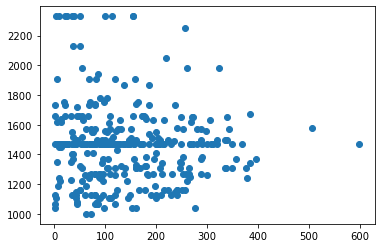

In [12]:
# Not correlated
plt.scatter(nhpd_fl_census_tract['TotalUnits'], nhpd_fl_census_tract['FairMarketRent_2BR'])

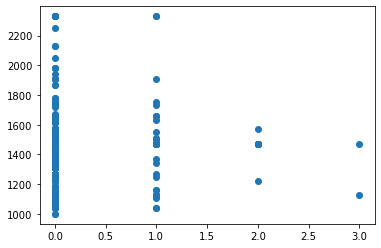

In [13]:
# Not correlated
plt.scatter(nhpd_fl_census_tract['NumberActivePublicHousing'], nhpd_fl_census_tract['FairMarketRent_2BR'])

**Transforming Target Variable `FairMarketRent`**

NormaltestResult(statistic=84.28091113022276, pvalue=4.99611795451515e-19)

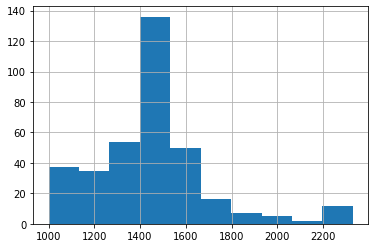

In [14]:
# Looking at distribution, Normal if p>0.05
nhpd_fl_census_tract.FairMarketRent_2BR.hist()
normaltest(nhpd_fl_census_tract.FairMarketRent_2BR.values)

NormaltestResult(statistic=21.690162671062456, pvalue=1.9500287760958436e-05)

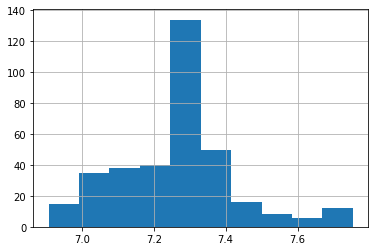

In [15]:
# Testing log transformation
log_medv = np.log(nhpd_fl_census_tract.FairMarketRent_2BR)
log_medv.hist();
normaltest(log_medv)

NormaltestResult(statistic=49.81372640409558, pvalue=1.5243572120174345e-11)

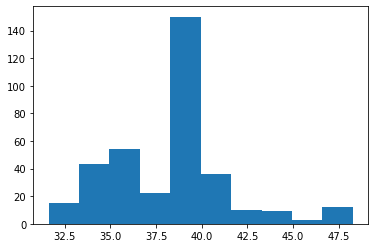

In [16]:
# Sqrt Tranformation
sqrt_medv = np.sqrt(nhpd_fl_census_tract.FairMarketRent_2BR)
plt.hist(sqrt_medv)
normaltest(sqrt_medv)

-0.8275170558873227


NormaltestResult(statistic=1.549869900694004, pvalue=0.46073375059479993)

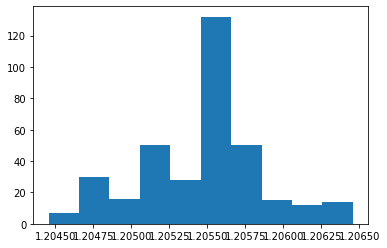

In [17]:
# Boxcox tranformation
bc_result = boxcox(nhpd_fl_census_tract.FairMarketRent_2BR)
boxcox_medv = bc_result[0]
lam = bc_result[1]
print(lam)
plt.hist(boxcox_medv);
normaltest(boxcox_medv)

**Selecting useful columns**

In [18]:
# Getting numeric columns
data = copy.deepcopy(nhpd_fl_census_tract.replace(-666666666, np.nan).dropna())
mask1 = data.dtypes == np.float
mask2 = data.dtypes == np.int
mask = mask1 + mask2
num_cols = data.columns[mask]

/Users/lprichard/miniconda3/envs/a37_ml/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [19]:
# Check null entries
data[num_cols].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 0 to 353
Data columns (total 89 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CensusTract                               326 non-null    float64
 1   CountyCode                                326 non-null    float64
 2   ActiveSubsidies                           326 non-null    int64  
 3   TotalInconclusiveSubsidies                326 non-null    int64  
 4   TotalInactiveSubsidies                    326 non-null    int64  
 5   TotalUnits                                326 non-null    float64
 6   NumberActiveSection8                      326 non-null    int64  
 7   NumberInconclusiveSection8                326 non-null    int64  
 8   NumberInactiveSection8                    326 non-null    int64  
 9   NumberActiveSection202                    326 non-null    int64  
 10  NumberActiveHUDInsured                

/Users/lprichard/miniconda3/envs/a37_ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


In [20]:
# Remove non ID numeric columns
rem_cols = ['CensusTract', 'CountyCode']  #, 'StudioOneBedroomUnits', 'TwoBedroomUnits', 'ThreePlusBedroomUnits'
an_cols = num_cols.drop(rem_cols)
an_cols

Index(['ActiveSubsidies', 'TotalInconclusiveSubsidies',
       'TotalInactiveSubsidies', 'TotalUnits', 'NumberActiveSection8',
       'NumberInconclusiveSection8', 'NumberInactiveSection8',
       'NumberActiveSection202', 'NumberActiveHUDInsured',
       'NumberInconclusiveHUDInsured', 'NumberInactiveHud',
       'NumberActiveLihtc', 'NumberInconclusiveLihtc', 'NumberInactiveLihtc',
       'NumberActiveSection515', 'NumberInactiveSection515',
       'NumberActiveSection538', 'NumberActiveHome', 'NumberInconclusiveHome',
       'NumberInactiveHome', 'NumberActivePublicHousing',
       'NumberInactivePublicHousing', 'NumberActiveState',
       'NumberInactiveState', 'NumberActivePBV', 'NumberActiveMR',
       'FairMarketRent_2BR', 'total-households',
       'total-renter-occupied-households', 'total-owner-occupied-households',
       'total-owner-occupied-households-mortgage', 'median-gross-rent',
       'median-household-income', 'median-property-value',
       'median-monthly-housing-

# **Feature Importance**

In [21]:
# Measure the skew of the distribution
skew_limit = 0.75
skew_vals = data[an_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

,Skew
median-house-age,12.707901
NumberInactiveSection515,12.220593
ratio-to-mean-foreclosure-rate,8.300195
NumberInactiveSection8,7.924193
NumberInactivePublicHousing,7.843574
...,...
housing-loss-index,1.317345
FairMarketRent_2BR,1.253335
pct-af-am,1.245393
TotalUnits,0.953601


In [22]:
# Testing least skewed cols to select the best for analysis
# tcols = ['NumberActiveState', 'NumberActiveLihtc', 'ActiveSubsidies', 'TotalUnits', 'TotalInactiveSubsidies', 'FairMarketRent_2BR']

# tcols = ['total-households', 'NumberActivePublicHousing', 'NumberActiveHome', 'avg-foreclosure-sales',  
#          'total-foreclosure-sales', 'pct-white', 'avg-eviction-rate', 'avg-evictions', 'total-evictions', 
#          'public-transport-to-work', 'immigrant-status', 'avg-housing-loss-rate', 'median-household-income', 
#          'total-renter-occupied-households', 'FairMarketRent_2BR', 'housing-loss-index', 'pct-af-am', 'TotalUnits',
#          'evictions-pct-total-housing-loss', 'pct-non-white', 'median-monthly-housing-cost', 'median-property-value',
#          'median-gross-rent']

tcols = ['FairMarketRent_2BR', 'median-monthly-housing-cost', 'median-property-value',
         'median-gross-rent']

In [23]:
data[tcols]

,FairMarketRent_2BR,median-monthly-housing-cost,median-property-value,median-gross-rent
0,1220.0,1186.0,128000.0,905.0
1,1070.0,890.0,127800.0,773.0
2,1070.0,1032.0,94200.0,983.0
3,1070.0,1050.0,89300.0,984.0
4,1220.0,969.0,90500.0,1058.0
...,...,...,...,...
349,1980.0,2313.0,402200.0,1617.0
350,1130.0,1082.0,122100.0,706.0
351,1500.0,1568.0,264000.0,962.0
352,1160.0,1594.0,263500.0,385.0


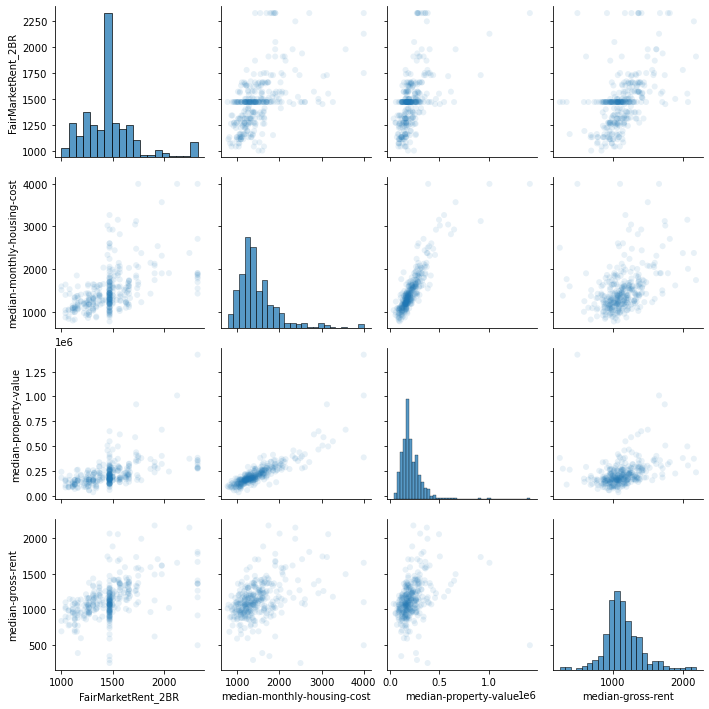

In [24]:
# Compare feature relations
sns.pairplot(data[tcols], plot_kws=dict(alpha=.1, edgecolor='none'))

# Testing Linear Regression

In [25]:
lr = LinearRegression()

In [26]:
# Define data sets
y_col = "FairMarketRent_2BR"

X = data[tcols].drop(y_col, axis=1)
y = data[y_col]

In [27]:
# Split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)

In [28]:
# Scale the training data
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

In [29]:
# Do a boxcox tranformation on the y data
bc_result1 = boxcox(y_train)
y_train_bc = bc_result1[0]
lam1 = bc_result1[1]
lam1

-1.0582247705706254

In [30]:
# Run linear regression on transformed data
lr.fit(X_train_s, y_train_bc)
X_test_s = s.transform(X_test)
y_pred_bc = lr.predict(X_test_s)

In [31]:
# Determine R2 score
y_pred_tran = inv_boxcox(y_pred_bc,lam1)
r2_score(y_pred_tran,y_test)

-0.4465449132415984

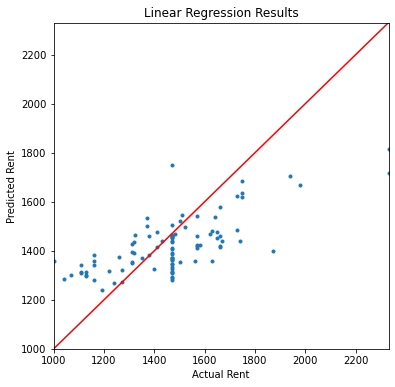

In [35]:
# Compare actual vs predicted rent price
f = plt.figure(figsize=(6,6))
ax = plt.axes()

# Plot the test data and predictions
ax.plot(y_test, y_pred_tran, 
         marker='o', ls='', ms=3.0)

xvals = np.linspace(y_test.min(), y_test.max(),100)
plt.plot(xvals, xvals, '-r')

lim = (y_test.min(), y_test.max())

ax.set(xlabel='Actual Rent', 
       ylabel='Predicted Rent', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

# Testing polynomial features

In [36]:
# Add polynomial features
pf2 = PolynomialFeatures(degree=2, include_bias=False)
X_pf2 = pf2.fit_transform(X)

In [37]:
# Split data into test and training sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pf2, y, test_size=0.3, random_state=72018)

In [38]:
# Scale data
X_train2_s = s.fit_transform(X_train2)

In [39]:
# Do a boxcox tranformation on the y data
bc_result2 = boxcox(y_train2)
y_train2_bc = bc_result2[0]
lam2 = bc_result2[1]
lam2

-1.0582247705706254

In [40]:
# Run linear regression on transformed data
lr.fit(X_train2_s, y_train2_bc)
X_test2_s = s.transform(X_test2)
y_pred_bc2 = lr.predict(X_test2_s)

In [41]:
# Calculate R2 score
y_pred_tran2 = inv_boxcox(y_pred_bc2,lam2)
r2_score(y_pred_tran2,y_test2)

0.08571608352951987

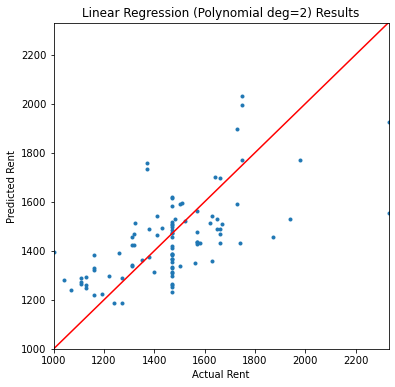

In [42]:
# Compare actual vs predicted rent price
f = plt.figure(figsize=(6,6))
ax = plt.axes()

# Plot the test data and predictions
ax.plot(y_test2, y_pred_tran2, 
         marker='o', ls='', ms=3.0)

xvals = np.linspace(y_test2.min(), y_test2.max(),100)
plt.plot(xvals, xvals, '-r')

lim = (y_test2.min(), y_test2.max())

ax.set(xlabel='Actual Rent', 
       ylabel='Predicted Rent', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression (Polynomial deg=2) Results');

# Tuning Hyperparameters

In [43]:
# Testing parameters with Grid Search CV
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

# Define estimator pipeline
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(1, 40, 40) # np.geomspace(4, 40, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [44]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 1.        ,  1.09920441,  1.20825033,  1.32811409,  1.45986886,
        1.60469429,  1.76388703,  1....09,  2.34264322,
        2.57504376,  2.83049945,  3.11129747,  3.41995189,  3.7592262 ,
        4.13215801,  4.54208629,  4.99268128,  5.48797727,  6.0324088 ,
        6.63085035,  7.28865993,  8.01172712,  8.80652577,  9.68017195,
       10.64048767, 11.69607095, 12.85637275, 14.1317816 , 15.53371662,
       17.07472978, 18.76861824, 20.63054791, 22.6771892 , 24.92686633,
       27.39972134, 30.11789448, 33.10572237, 36.38995596

In [45]:
grid.best_score_, grid.best_params_

(0.37734402461265565,
 {'polynomial_features__degree': 1,
  'ridge_regression__alpha': 20.63054790590539})

# Testing Ridge Regression

In [46]:
# Defining & running ridge regression model
rr = Ridge(alpha=20)
rr = rr.fit(X_train_s, y_train_bc)
y_pred_bcrr = rr.predict(X_test_s)

In [47]:
# Calculate R2 score
y_pred_rr = inv_boxcox(y_pred_bcrr,lam1)
r2_score(y_pred_rr,y_test)

-0.6498160738994181

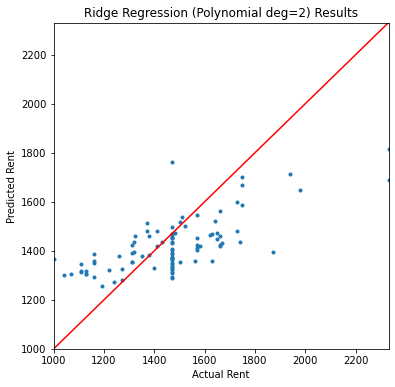

In [48]:
# Compare actual vs predicted rent price
f = plt.figure(figsize=(6,6))
ax = plt.axes()

# Plot the test data and predictions
ax.plot(y_test2, y_pred_rr, 
         marker='o', ls='', ms=3.0)

xvals = np.linspace(y_test2.min(), y_test2.max(),100)
plt.plot(xvals, xvals, '-r')

lim = (y_test2.min(), y_test2.max())

ax.set(xlabel='Actual Rent', 
       ylabel='Predicted Rent', 
       xlim=lim,
       ylim=lim,
       title='Ridge Regression (Polynomial deg=2) Results');